In [1]:
%matplotlib inline
import math
import torch
import torch.nn.functional as F
from torch import nn
import numpy as np
import os
import re
from collections import Counter
import numpy as np
from visualization import TrainingVisualizer

In [2]:
# 检查GPU是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# 设置阈值
threshold = 5

# 加载文本数据
with open('data/time_machine_txt/timemachine.txt', 'r') as f:
    text = f.read()

# 将所有字符转换为小写
text = text.lower()

# 移除所有标点符号
text = re.sub(r'[^\w\s]', '', text)  # 仅保留字母、数字和空格
# 截取前 n 个字符
n = 3000
text = text[:n]

# 计算字符的词频
char_counts = Counter(text)

# 创建字符映射表，保留词频不低于阈值的字符，其他字符设为<unk>
chars = sorted([ch for ch, count in char_counts.items() if count >= threshold])
chars.append('<unk>')  # 添加<unk>标记

char_to_idx = {ch: idx for idx, ch in enumerate(chars)}
idx_to_char = {idx: ch for idx, ch in enumerate(chars)}
unk_idx = char_to_idx['<unk>']

# 转换文本为索引，如果字符词频低于阈值，则转换为<unk>
text_as_int = np.array([char_to_idx.get(c, unk_idx) for c in text])

# 打印结果示例
print("Unique characters:", len(chars))
print("Character to Index mapping:", char_to_idx)
print("First 100 characters as indices:", text_as_int[:10])

Unique characters: 27
Character to Index mapping: {'\n': 0, ' ': 1, '_': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, '<unk>': 26}
First 100 characters as indices: [20 10  7  1 20 11 14  7  1 14]


In [4]:
# 定义超参数
vocab_size = len(chars)  # 字符的个数
seq_size = 50  # 序列长度 - 一个句子100个单词
batch_size = 128
hidden_size = 256
embedding_size = 64  # input_size 嵌入向量的大小
num_layers = 1
lr = 10
num_epochs = 50000

In [5]:
def create_dataset(text_as_int, seq_size, batch_size):
    sequences = []
    targets = []
    for i in range(0, len(text_as_int) - seq_size):
        sequences.append(text_as_int[i:i + seq_size])
        targets.append(text_as_int[i + 1:i + seq_size + 1])
    sequences = torch.tensor(sequences, dtype=torch.long)
    targets = torch.tensor(targets, dtype=torch.long)
    dataset = torch.utils.data.TensorDataset(sequences, targets)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return dataloader

dataloader = create_dataset(text_as_int, seq_size, batch_size)

C:\Users\20703\AppData\Local\Temp\ipykernel_15980\833452756.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:277.)
  sequences = torch.tensor(sequences, dtype=torch.long)


In [6]:
def initialize_LSTM_Wb(embedding_size, hidden_size, vocab_size, device):
    """
    hidden_size：神经元个数
    # X's size: (batch_size, seq_size, vocab_size) -> (seq_size, batch_size, vocab_size) -> (seq_size, batch_size, embedding_size)
    但注意：这里我们需要的X的维度：(batch_size, embedding_size)
    # H = torch.normal(0, 1, (batch_size, hidden_size))
    """
    # 输入门 I
    W_xi =  torch.normal(0, 1, (embedding_size, hidden_size), device = device) * 0.01
    W_hi = torch.normal(0, 1, (hidden_size, hidden_size), device = device) * 0.01
    b_i = torch.zeros((1, hidden_size), device = device) # 注意这里的偏置项是加在神经元上，不是batch_size*hidden_size

    # 遗忘门 F
    W_xf =  torch.normal(0, 1, (embedding_size, hidden_size), device = device) * 0.01
    W_hf = torch.normal(0, 1, (hidden_size, hidden_size), device = device) * 0.01
    b_f = torch.zeros((1, hidden_size), device = device) 

    # 输出门 O
    W_xo =  torch.normal(0, 1, (embedding_size, hidden_size), device = device) * 0.01
    W_ho = torch.normal(0, 1, (hidden_size, hidden_size), device = device) * 0.01
    b_o = torch.zeros((1, hidden_size), device = device) 
    
    # 候选记忆元 tilde_C
    W_xc = torch.normal(0, 1, (embedding_size, hidden_size), device = device) * 0.01
    W_hc = torch.normal(0, 1, (hidden_size, hidden_size), device = device) * 0.01
    b_c = torch.zeros((1, hidden_size), device = device)

    # 输出层参数
    W_hq = torch.normal(0, 1, (hidden_size, vocab_size), device = device) * 0.01
    b_q = torch.zeros((1, vocab_size), device = device)

    # 附加梯度
    I_params = [W_xi, W_hi, b_i]
    F_params = [W_xf, W_hf, b_f]
    O_params = [W_xo, W_ho, b_o]
    C_params = [W_xc, W_hc, b_c]
    Output_layer_params = [W_hq, b_q]
    params = [I_params, F_params, O_params, C_params, Output_layer_params]
    for i_param in params:
        for param in i_param:
            param.requires_grad_(True)
    
    return params

In [7]:
# 定义一个函数初始化隐变量H
def initialize_LSTM_HC(batch_size, hidden_size, device):
    H = torch.zeros((batch_size, hidden_size), device = device)
    C = torch.zeros((batch_size, hidden_size), device = device)
    return H, C

In [8]:
# 定义矩阵计算
def LSTM_calculate(inputs, params, H, C, device): 
    # inputs的形状：(seq_size，batch_size, embedding_size)
    # 需要传入上一个时间步的隐状态H和记忆元C
    outputs = []
    
    I_params, F_params, O_params, C_params, Output_layer_params = params
    W_xi, W_hi, b_i = I_params
    W_xf, W_hf, b_f = F_params
    W_xo, W_ho, b_o = O_params
    W_xc, W_hc, b_c = C_params
    W_hq, b_q = Output_layer_params
    
    for X in inputs: # X的形状：(batch_size, embedding_size)
        I = torch.sigmoid(torch.mm(X, W_xi) + torch.mm(H, W_hi) + b_i)
        F = torch.sigmoid(torch.mm(X, W_xf) + torch.mm(H, W_hf) + b_f)
        O = torch.sigmoid(torch.mm(X, W_xo) + torch.mm(H, W_ho) + b_o)
        tilde_C = torch.tanh(torch.mm(X, W_xc) + torch.mm(H, W_hc) + b_c)
        C = torch.mul(F, C) + torch.mul(I, tilde_C)
        H = torch.mul(O, torch.tanh(C)) 
        O = torch.mm(H, W_hq) + b_q
        outputs.append(O) # outputs是每一个时间步的输出 - [tensor(batch_size, vocab_size), tensor(batch_size, vocab_size), ......]
        
    outputs = torch.stack(outputs)
    return outputs, H, C # outputs 的 size：(seq_size, batch_size, vocab_size)；H 的 size：(batch_size, hidden_size)

In [29]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_size, vocab_size, initialize_LSTM_Wb, initialize_LSTM_HC, LSTM_calculate, device):
        super(LSTMModel, self).__init__()
        self.device = device
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.params = initialize_LSTM_Wb(embedding_size, hidden_size, vocab_size, device)
        self.initialize_LSTM_HC = initialize_LSTM_HC
        self.LSTM_calculate = LSTM_calculate

    def forward(self, X, H, C): 
        # 输入的X的形状为：(batch_size, seq_size)；H的形状为：(batch_size, hidden_size)
        X = self.embedding(X) # 此时X的形状变为：(batch_size, seq_size, embedding_size)
        X = X.permute(1, 0, 2).to(self.device) # 此时X的形状变为：(seq_size, batch_size, embedding_size)
        Y, H, C = self.LSTM_calculate(X, self.params, H, C, self.device)
        return Y, H, C # 返回Y的size：(seq_size, batch_size, vocab_size)

    def begin_HC(self, batch_size, hidden_size, device):
        H, C = self.initialize_LSTM_HC(batch_size, hidden_size, device)
        return H, C

In [30]:
def grad_clipping(net, theta):
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm # 整体进行一个缩放

In [31]:
def LSTM_train_epoch(train_iter, model, criterion, optimizer, device):
    """训练网络一个迭代周期"""
    H = None
    C = None
    
    for X, Y in train_iter: # X，Y的形状：(batch_size, seq_size)
        
        if H is None and C is  None: # 如果处于第一个迭代周期
            H, C = model.begin_HC(X.shape[0], hidden_size, device)
        else: 
            H = H.detach()
            C = C.detach()

        Y = Y.T # Y的size从(batch_size, seq_size) -> (seq_size, batch_size)
        Y_hat, H, C = model(X, H, C) # Y_hat的size：(seq_size, batch_size, vocab_size)
        # 为了计算交叉熵损失，我们需要调整Y_hat和Y的size，这也是课本代码中使用reshape的原因
        Y_hat = Y_hat.reshape(-1, Y_hat.shape[2]) # size变成：(seq_size*batch_size, vocab_size)
        Y = Y.reshape(-1) # 把Y变为一维的张量
        Y_hat, Y = Y_hat.to(device), Y.to(device)

        optimizer.zero_grad()
        # print(Y_hat, Y)
        loss = criterion(Y_hat, Y.long()).mean()
        loss.backward()
        grad_clipping(model, 1)
        optimizer.step()

        perplexity = math.exp(loss)
        
    return perplexity

In [32]:
def LSTM_train(model, train_iter, lr, num_epochs, device):
    """训练模型"""
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    visualizer = TrainingVisualizer(xlabel='Epoch', ylabel='Perplexity', title='Train LSTM_scratch in Time_Machine', legend=['Perplexity'])  

    predict = lambda prefix: text_prediction(prefix, 50, model, device) # 匿名函数，输入prefix预测50个token
    
    # 训练和预测
    for epoch in range(num_epochs):
        perplexity = LSTM_train_epoch(train_iter, model, criterion, optimizer, device)
        visualizer.add(epoch, [perplexity])

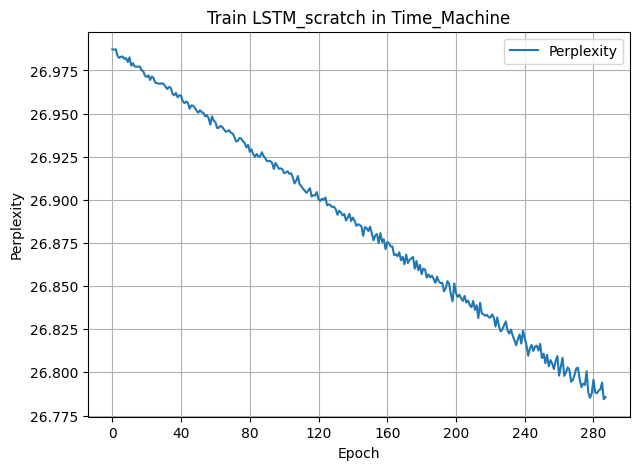

In [ ]:
model = LSTMModel(embedding_size, hidden_size, vocab_size, initialize_LSTM_Wb, initialize_LSTM_HC, LSTM_calculate, device)

LSTM_train(model, dataloader, lr, num_epochs, device)